In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.utils import np_utils, plot_model
from sys import stdout

Using TensorFlow backend.


In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font', family = 'serif', size = 17)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2

In [4]:
fp = open('data/train.txt','r')
raw_x = []
raw_y = []
for line in fp:
    tmp = list(map(float, line.split(' ')))
    a = tmp[-1]
    raw_x.append(np.array(tmp[:-1]))
    if(a > 0.5):
        raw_y.append(2)
    elif(a < -0.5):
        raw_y.append(1)
    else:
        raw_y.append(0)
fp.close()
raw_y = np.array(raw_y)

In [5]:
def getMat(arr, win):
    ans = []
    N = len(arr) - win + 1
    batch_size = N/50
    for i in range(len(arr) - win + 1):
        if(i%batch_size == 0):
            stdout.write('=')
            stdout.flush()
        ans.append(np.array([np.array(vec) for vec in arr[i:i+win]]))
    return ans

In [6]:
print np.shape(raw_x), np.shape(raw_y)
n_feat = np.shape(raw_x)[1]
print n_feat

(1262394, 13) (1262394,)
13


### Getting price information

In [7]:
fp = open('data/prcs.txt','r')
prc = []
for line in fp:
    prc.append(np.array(map(float, line.split(' '))))
print np.shape(prc)
ask = prc[0]
bid = prc[1]
print ask[:5]
print bid[:5]

(2, 1262394)
[ 10027.  10027.  10027.  10027.  10027.]
[ 10026.  10026.  10026.  10026.  10026.]


### Generating matrix data

In [8]:
win = 25
raw_x = getMat(raw_x , win)
raw_y = raw_y[win-1:]
ask = ask[win-1:]
bid = bid[win-1:]
print "\n",np.shape(raw_x), np.shape(raw_y), np.shape(ask), np.shape(bid)

(1262370, 25, 13) (1262370,) (1262370,) (1262370,)


In [9]:
N_train = len(raw_y)*7/10
N_test = len(raw_y) - N_train
x_train = raw_x[:N_train]
x_test = raw_x[N_train:]
y_train = raw_y[:N_train]
y_test = raw_y[N_train:]
ask_test = ask[N_train:]
bid_test = bid[N_train:]

In [10]:
def comp_cls_wts(y, pwr = 0.64):
    dic = {}
    for x in set(y):
        dic[x] = (len(y))**pwr/(list(y).count(x))**pwr
    return dic
cls_wts = comp_cls_wts(y_train)
cls_wts

{0: 1.073499662140589, 1: 6.5846097128447765, 2: 6.6100268173202865}

In [11]:
y_train = np_utils.to_categorical(y_train, 3)
y_test = np_utils.to_categorical(y_test, 3)

In [12]:
x_train = np.array(x_train).reshape(N_train, win, n_feat, 1)
x_test = np.array(x_test).reshape(N_test, win, n_feat, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [13]:
n_cls = 3

In [14]:
n_cls = 3
model = Sequential()
model.add(Conv2D(16, kernel_size = (9, 2*n_feat - 1), input_shape = (win, n_feat, 1), padding = 'same'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.1))
model.add(Conv2D(32, kernel_size = (5, n_feat), padding='valid'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(n_cls, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 13, 16)        3616      
_________________________________________________________________
activation_1 (Activation)    (None, 25, 13, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 1, 32)         33312     
_________________________________________________________________
activation_2 (Activation)    (None, 21, 1, 32)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 1, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 672)               0         
__________

In [15]:
optimizer = SGD()
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
x_train = x_train[:120000]
y_train = y_train[:120000]
x_test = x_test[:40000]
y_test = y_test[:40000]

In [16]:
def getPnl(act, ask, bid, fee = 0.5):
    pnl = 0.
    pos = 0.
    prc = 0.
    n = len(act)
    flip = 0
    for i in range(n):
        if act[i] == 2 and pos < 1: 
            pnl -= (ask[i] + fee/(1-pos))*(1-pos)
            prc = (ask[i] + fee/(1-pos))
            pos = 1
            flip += 1
        elif act[i] == 1 and pos > -1:
            pnl += (bid[i] - fee/(pos+1))*(pos+1)
            prc = (bid[i] - fee/(pos+1))
            pos = -1
            flip += 1
    pnl += pos*prc
    return flip, pnl
print "start training"

start training


In [17]:
steps = []
train_loss = []
test_loss = []
train_accu = []
test_accu = []
in_pnl = []
out_pnl = []
in_flip = []
out_flip = []
for i in range(120):
    steps.append(i)
    res = model.fit(x_train, y_train, batch_size=512, epochs = 15, verbose = 0, validation_data=(x_test, y_test), 
                    class_weight = cls_wts)
    lr, ar = model.evaluate(x_train, y_train, batch_size=128)
    train_loss.append(lr)
    train_accu.append(ar)
    le, ae = model.evaluate(x_test, y_test, batch_size=128)
    test_loss.append(le)
    test_accu.append(ae)
    print "\n The loss of the model is ",le,lr
    print "The accuracy of the model is ",ae,ar
    in_pred = model.predict_classes(x_train)
    out_pred = model.predict_classes(x_test)
    inf, inp = getPnl(in_pred, ask, bid)
    outf, outp = getPnl(out_pred, ask_test, bid_test)
    in_pnl.append(inp)
    in_flip.append(inf)
    out_pnl.append(outp)
    out_flip.append(outf)
    print "The (flip, pnl) for the in sample is ", inf, inp
    print "The (flip, pnl) for the out sample is ", outf, outp

38400/40000 [===========================>..] - ETA: 0s
 The loss of the model is  0.664694284821 0.666574698321
The accuracy of the model is  0.731075 0.682825
39488/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  198 -133.75
The (flip, pnl) for the out sample is  96 -113.75
40000/40000 [==============================] - 0s     

 The loss of the model is  0.55691596818 0.603794070117
The accuracy of the model is  0.77875 0.704125
39904/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  377 -326.25
The (flip, pnl) for the out sample is  142 -302.75
39296/40000 [============================>.] - ETA: 0s
 The loss of the model is  0.633019702196 0.605497091993
The accuracy of the model is  0.69115 0.690675
40000/40000 [==============================] - 2s     
The (flip, pnl) for the in sample is  606 -625.75
The (flip, pnl) for the out sample is  197 -487.25
39296/40000 [============================>.] - ETA: 0s
 T

39424/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  606 -363.75
The (flip, pnl) for the out sample is  327 -566.25
39552/40000 [============================>.] - ETA: 0s
 The loss of the model is  0.717842280443 0.229465994322
The accuracy of the model is  0.754425 0.896266666667
39904/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  608 -360.75
The (flip, pnl) for the out sample is  326 -624.75
38912/40000 [============================>.] - ETA: 0s
 The loss of the model is  0.724579259359 0.228776702855
The accuracy of the model is  0.75685 0.896041666667
39488/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  618 -355.75
The (flip, pnl) for the out sample is  320 -589.75
39168/40000 [============================>.] - ETA: 0s
 The loss of the model is  0.769910472274 0.235213179048
The accuracy of the model is  0.732725 0.8919
39392/40000 [============================>.] -

39808/40000 [============================>.] - ETA: 0s
 The loss of the model is  0.957460203534 0.10814672667
The accuracy of the model is  0.772675 0.953375
39840/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  514 -89.75
The (flip, pnl) for the out sample is  310 -543.75
39296/40000 [============================>.] - ETA: 0s
 The loss of the model is  0.960127405316 0.130529292966
The accuracy of the model is  0.772675 0.941575
39232/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  544 -134.75
The (flip, pnl) for the out sample is  298 -549.75
39296/40000 [============================>.] - ETA: 0s
 The loss of the model is  0.966511013371 0.113312691436
The accuracy of the model is  0.762125 0.95075
39232/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  504 -52.75
The (flip, pnl) for the out sample is  320 -602.75
39296/40000 [============================>.] - ETA: 0s
 The

39488/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  454 140.25
The (flip, pnl) for the out sample is  283 -502.25
39552/40000 [============================>.] - ETA: 0s
 The loss of the model is  1.06584633415 0.040272664802
The accuracy of the model is  0.800425 0.98525
39968/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  412 291.25
The (flip, pnl) for the out sample is  255 -485.25
38912/40000 [============================>.] - ETA: 0s
 The loss of the model is  0.997556476947 0.0372996626495
The accuracy of the model is  0.818325 0.986683333333
39456/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  397 338.75
The (flip, pnl) for the out sample is  221 -428.25
39040/40000 [============================>.] - ETA: 0s
 The loss of the model is  1.02780003502 0.0419742842532
The accuracy of the model is  0.80745 0.984458333333
39328/40000 [============================>.] - E

38784/40000 [============================>.] - ETA: 0s
 The loss of the model is  1.09875379585 0.0380403392637
The accuracy of the model is  0.803875 0.985608333333
39168/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  426 274.25
The (flip, pnl) for the out sample is  271 -518.25
38912/40000 [============================>.] - ETA: 0s
 The loss of the model is  1.05583446589 0.026596855614
The accuracy of the model is  0.818575 0.991116666667
39840/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  393 438.75
The (flip, pnl) for the out sample is  231 -447.25
38912/40000 [============================>.] - ETA: 0s
 The loss of the model is  1.05727406488 0.0199253621123
The accuracy of the model is  0.82695 0.994375
39904/40000 [============================>.] - ETA: 0sThe (flip, pnl) for the in sample is  387 535.75
The (flip, pnl) for the out sample is  213 -412.25
38912/40000 [============================>.] - E

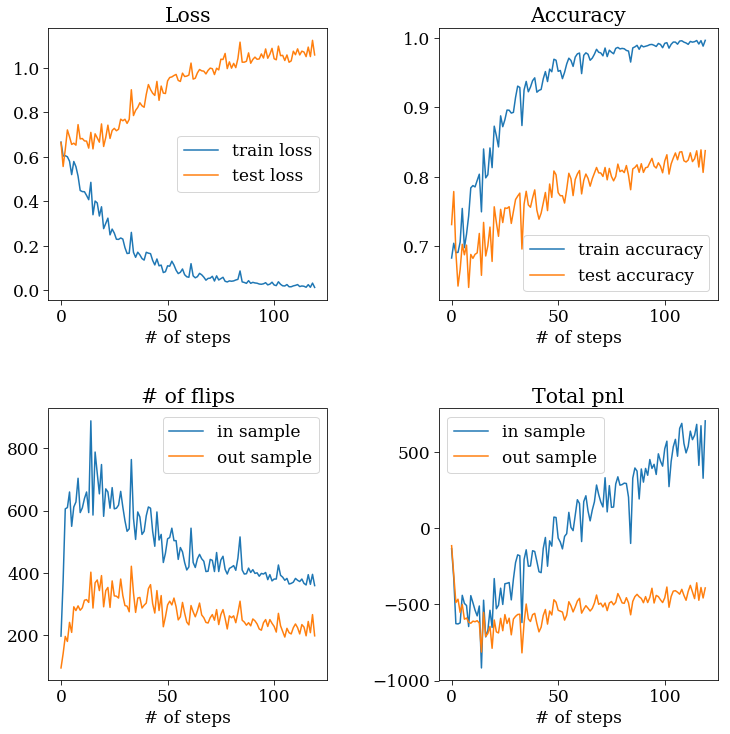

In [18]:
fig, axes = plt.subplots(2,2, figsize = (12, 12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

axes[0][0].set_title('Loss')
axes[0][0].plot(steps, train_loss, label = 'train loss')
axes[0][0].plot(steps, test_loss, label = 'test loss')
axes[0][0].set_xlabel('# of steps')
axes[0][0].legend()

axes[0][1].set_title('Accuracy')
axes[0][1].plot(steps, train_accu, label = 'train accuracy')
axes[0][1].plot(steps, test_accu, label = 'test accuracy')
axes[0][1].set_xlabel('# of steps')
axes[0][1].legend()

axes[1][0].set_title('# of flips')
axes[1][0].plot(steps, in_flip, label ='in sample')
axes[1][0].plot(steps, out_flip, label ='out sample')
axes[1][0].set_xlabel('# of steps')
axes[1][0].legend()

axes[1][1].set_title('Total pnl')
axes[1][1].plot(steps, in_pnl, label ='in sample')
axes[1][1].plot(steps, out_pnl, label ='out sample')
axes[1][1].set_xlabel('# of steps')
axes[1][1].legend()


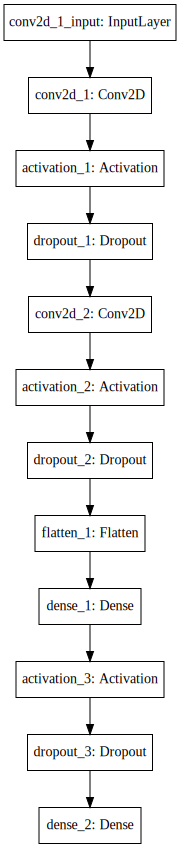

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
plot_model(model, to_file='model.png')